CÀI ĐẶT KNEED

In [2]:
!pip install kneed

KHAI BÁO THƯ VIỆN CẦN THIẾT

In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from kneed import KneeLocator
import warnings
warnings.filterwarnings("ignore")

ĐỌC DỮ LIỆU

In [4]:
df = pd.read_csv('amazon_2024_valentines_best_sellers.csv')

EDA

In [5]:
dfCopy = df

In [6]:
dfCopy.head(5)

,title,brand,description,starsBreakdown/3star,starsBreakdown/4star,starsBreakdown/5star,reviewsCount,price,price/currency,price/value,categoryPageData/productPosition
0,"Ferrero Rocher, 24 Count, Premium Milk Chocola...",Ferrero Rocher,Ferrero Rocher's milk chocolate gift box offer...,0.02,0.07,0.89,20021.0,NaN,$,11.39,7
1,"HERSHEY'S NUGGETS Assorted Chocolate, Valentin...",HERSHEY'S,This HERSHEY'S NUGGETS candy assortment is fil...,0.03,0.10,0.84,18891.0,NaN,$,10.69,16
2,LEGO Icons Flower Bouquet Building Decoration ...,LEGO,Giving and receiving beautiful flowers is such...,0.01,0.05,0.92,19395.0,NaN,$,47.99,2
3,BodyRefresh Shower Steamers Aromatherapy - 8 P...,BodyRefresh,NaN,0.07,0.15,0.67,593.0,NaN,$,9.99,10
4,JoJowell Shower Steamers Aromatherapy - 21Pcs ...,JoJowell,NaN,0.10,0.15,0.63,816.0,NaN,$,21.99,11


In [7]:
dfCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   title                             218 non-null    object 
 1   brand                             217 non-null    object 
 2   description                       46 non-null     object 
 3   starsBreakdown/3star              218 non-null    float64
 4   starsBreakdown/4star              218 non-null    float64
 5   starsBreakdown/5star              218 non-null    float64
 6   reviewsCount                      216 non-null    float64
 7   price                             0 non-null      float64
 8   price/currency                    169 non-null    object 
 9   price/value                       169 non-null    float64
 10  categoryPageData/productPosition  218 non-null    int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 18.9+ KB


In [8]:
dfCopy.isnull().sum()

title                                 0
brand                                 1
description                         172
starsBreakdown/3star                  0
starsBreakdown/4star                  0
starsBreakdown/5star                  0
reviewsCount                          2
price                               218
price/currency                       49
price/value                          49
categoryPageData/productPosition      0
dtype: int64

XỬ LÝ DỮ LIỆU VÀ TÌM SỐ CỤM PHÙ HỢP

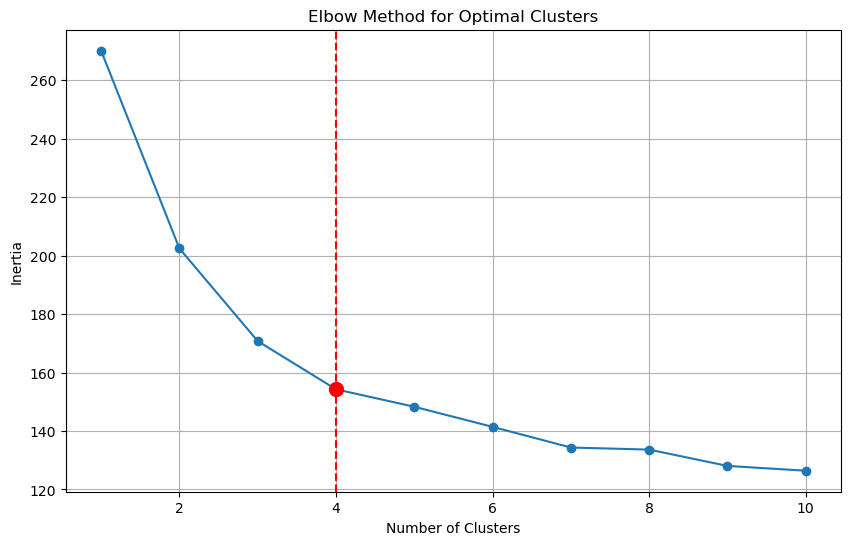

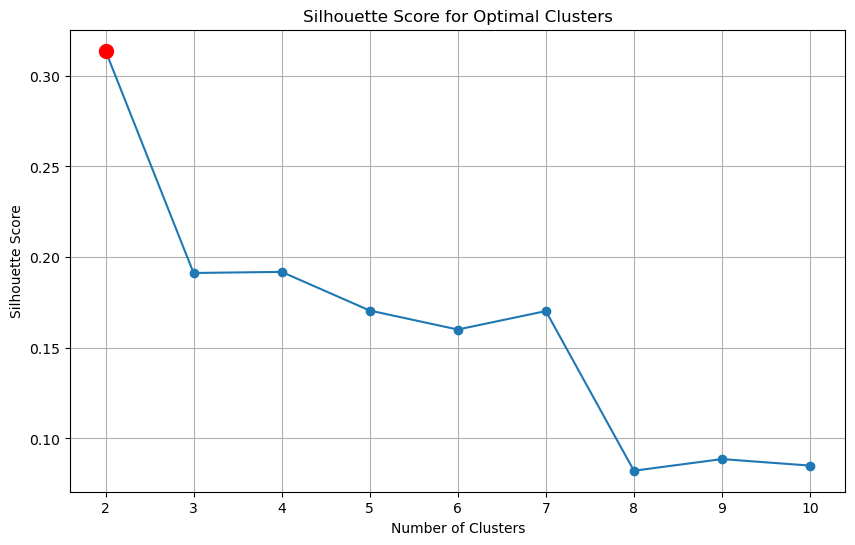

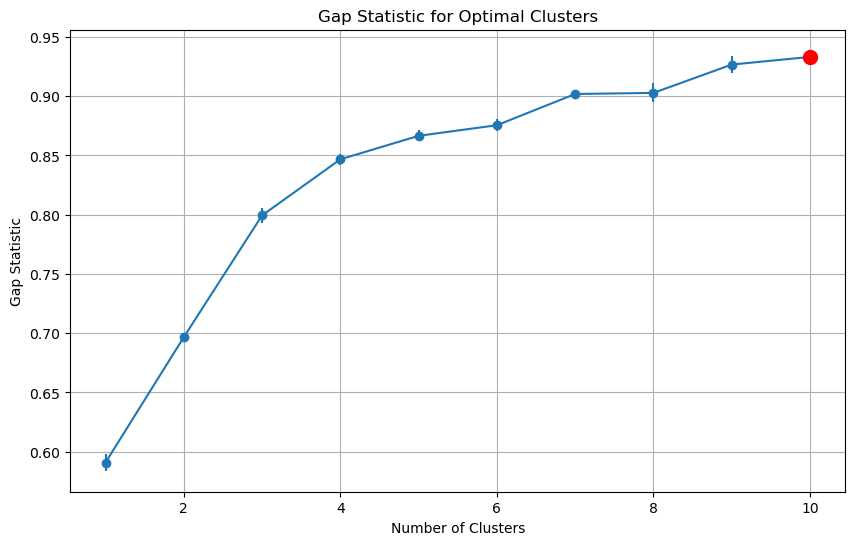



Optimal number of clusters (Elbow Method): 4
Optimal number of clusters (Silhouette Score): 2
Optimal number of clusters (Gap Statistic): 10




In [9]:
import re

def preprocess_title(title):
    """
    Convert title to lowercase and remove punctuation.
    """
    if isinstance(title, str):  
        title = title.lower()
        title = re.sub(r'[^\w\s]', '', title)  
    return title


dfCopy['Refined Title'] = dfCopy['title'].apply(preprocess_title)



def load_glove_embeddings(file_path):
    """
    Load GloVe embeddings from a file into a dictionary.
    """
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


glove_file_path = 'C:/Users/User/OneDrive/a/OneDrive/Máy tính/GloVe_50d/glove.6B/glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)


def text_to_vector(text, embeddings):
    """
    Convert text into a vector by averaging GloVe vectors of its words.
    """
    if isinstance(text, str): 
        words = text.split()
        vectors = [embeddings.get(word, np.zeros(len(next(iter(embeddings.values()))))) for word in words]
        return np.mean(vectors, axis=0) if vectors else np.zeros(len(next(iter(embeddings.values()))))
    else:
        return np.zeros(len(next(iter(embeddings.values()))))


dfCopy['Vector'] = dfCopy['Refined Title'].apply(lambda x: text_to_vector(x, glove_embeddings))

X = np.array(dfCopy['Vector'].tolist())

inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')

kneedle = KneeLocator(range(1, 11), inertia, curve='convex', direction='decreasing')
elbow_optimal_clusters = kneedle.elbow

plt.axvline(x=elbow_optimal_clusters, color='r', linestyle='--')
plt.scatter(elbow_optimal_clusters, inertia[elbow_optimal_clusters - 1], color='r', s=100, zorder=5)
plt.grid(True)
plt.show()

silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(X)
    score = silhouette_score(X, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')

silhouette_optimal_clusters = np.argmax(silhouette_scores) + 2

plt.scatter(silhouette_optimal_clusters, silhouette_scores[np.argmax(silhouette_scores)], color='r', s=100, zorder=5)
plt.grid(True)
plt.show()

def compute_gap_statistic(X, k_max=10, n_refs=10):
    """
    Compute the Gap Statistic for a range of cluster numbers.
    """
    gaps = []
    stds = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
        dispersion = np.sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))
        
        ref_disps = []
        for _ in range(n_refs):
            ref_points = np.random.uniform(low=np.min(X, axis=0), high=np.max(X, axis=0), size=X.shape)
            ref_dispersion = np.sum(np.min(cdist(ref_points, kmeans.cluster_centers_, 'euclidean'), axis=1))
            ref_disps.append(ref_dispersion)
        
        gap = np.mean(np.log(ref_disps)) - np.log(dispersion)
        gap_std = np.std(np.log(ref_disps))
        gaps.append(gap)
        stds.append(gap_std)
    
    return gaps, stds

gaps, stds = compute_gap_statistic(X)

plt.figure(figsize=(10, 6))
plt.errorbar(range(1, 11), gaps, yerr=stds, fmt='-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic for Optimal Clusters')

gap_optimal_clusters = np.argmax(gaps) + 1

plt.scatter(gap_optimal_clusters, gaps[np.argmax(gaps)], color='r', s=100, zorder=5)
plt.grid(True)
plt.show()

print("\n")
print("=================================================================")
print(f"Optimal number of clusters (Elbow Method): {elbow_optimal_clusters}")
print(f"Optimal number of clusters (Silhouette Score): {silhouette_optimal_clusters}")
print(f"Optimal number of clusters (Gap Statistic): {gap_optimal_clusters}")
print("=================================================================")
print("\n")

NHẬN DIỆN CÁC CỤM

In [10]:
import warnings
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")

kmeans = KMeans(n_clusters=gap_optimal_clusters, random_state=42)
dfCopy['Cluster'] = kmeans.fit_predict(X)

cluster_summary = dfCopy.groupby('Cluster')['title'].agg(list)

print(cluster_summary)


Cluster
0    [ChunRun Valentines Day Gifts - I Hope Your Da...
1    [HERSHEY'S NUGGETS Assorted Chocolate, Valenti...
2    [BodyRefresh Shower Steamers Aromatherapy - 8 ...
3    [2 Pcs Anniversary Date Night Gifts for Couple...
4    [ORIENTAL CHERRY Valentines Day Gifts for Kids...
5    [Ferrero Rocher, 24 Count, Premium Milk Chocol...
6    [LEGO Icons Flower Bouquet Building Decoration...
7    [Hallmark Valentines Day Cards for Kids and Ma...
8    [Body Restore Shower Steamers Aromatherapy 6 P...
9    [40 Date Ideas Card Games for Couples Date Nig...
Name: title, dtype: object


In [11]:
dfCopy.head(5)

,title,brand,description,starsBreakdown/3star,starsBreakdown/4star,starsBreakdown/5star,reviewsCount,price,price/currency,price/value,categoryPageData/productPosition,Refined Title,Vector,Cluster
0,"Ferrero Rocher, 24 Count, Premium Milk Chocola...",Ferrero Rocher,Ferrero Rocher's milk chocolate gift box offer...,0.02,0.07,0.89,20021.0,NaN,$,11.39,7,ferrero rocher 24 count premium milk chocolate...,"[-0.04784686, 0.32031354, -0.18485427, 0.09783...",5
1,"HERSHEY'S NUGGETS Assorted Chocolate, Valentin...",HERSHEY'S,This HERSHEY'S NUGGETS candy assortment is fil...,0.03,0.10,0.84,18891.0,NaN,$,10.69,16,hersheys nuggets assorted chocolate valentines...,"[-0.09465036270293323, 0.15106291332366792, -0...",1
2,LEGO Icons Flower Bouquet Building Decoration ...,LEGO,Giving and receiving beautiful flowers is such...,0.01,0.05,0.92,19395.0,NaN,$,47.99,2,lego icons flower bouquet building decoration ...,"[0.2082137249667069, 0.5833509346341779, -0.38...",6
3,BodyRefresh Shower Steamers Aromatherapy - 8 P...,BodyRefresh,NaN,0.07,0.15,0.67,593.0,NaN,$,9.99,10,bodyrefresh shower steamers aromatherapy 8 pa...,"[0.15067462963010517, 0.4685303956669356, -0.2...",2
4,JoJowell Shower Steamers Aromatherapy - 21Pcs ...,JoJowell,NaN,0.10,0.15,0.63,816.0,NaN,$,21.99,11,jojowell shower steamers aromatherapy 21pcs s...,"[0.25322112383858847, 0.4304769345527065, -0.2...",2


HIỂN THỊ CÁC BẢNG CHỮ MÀU

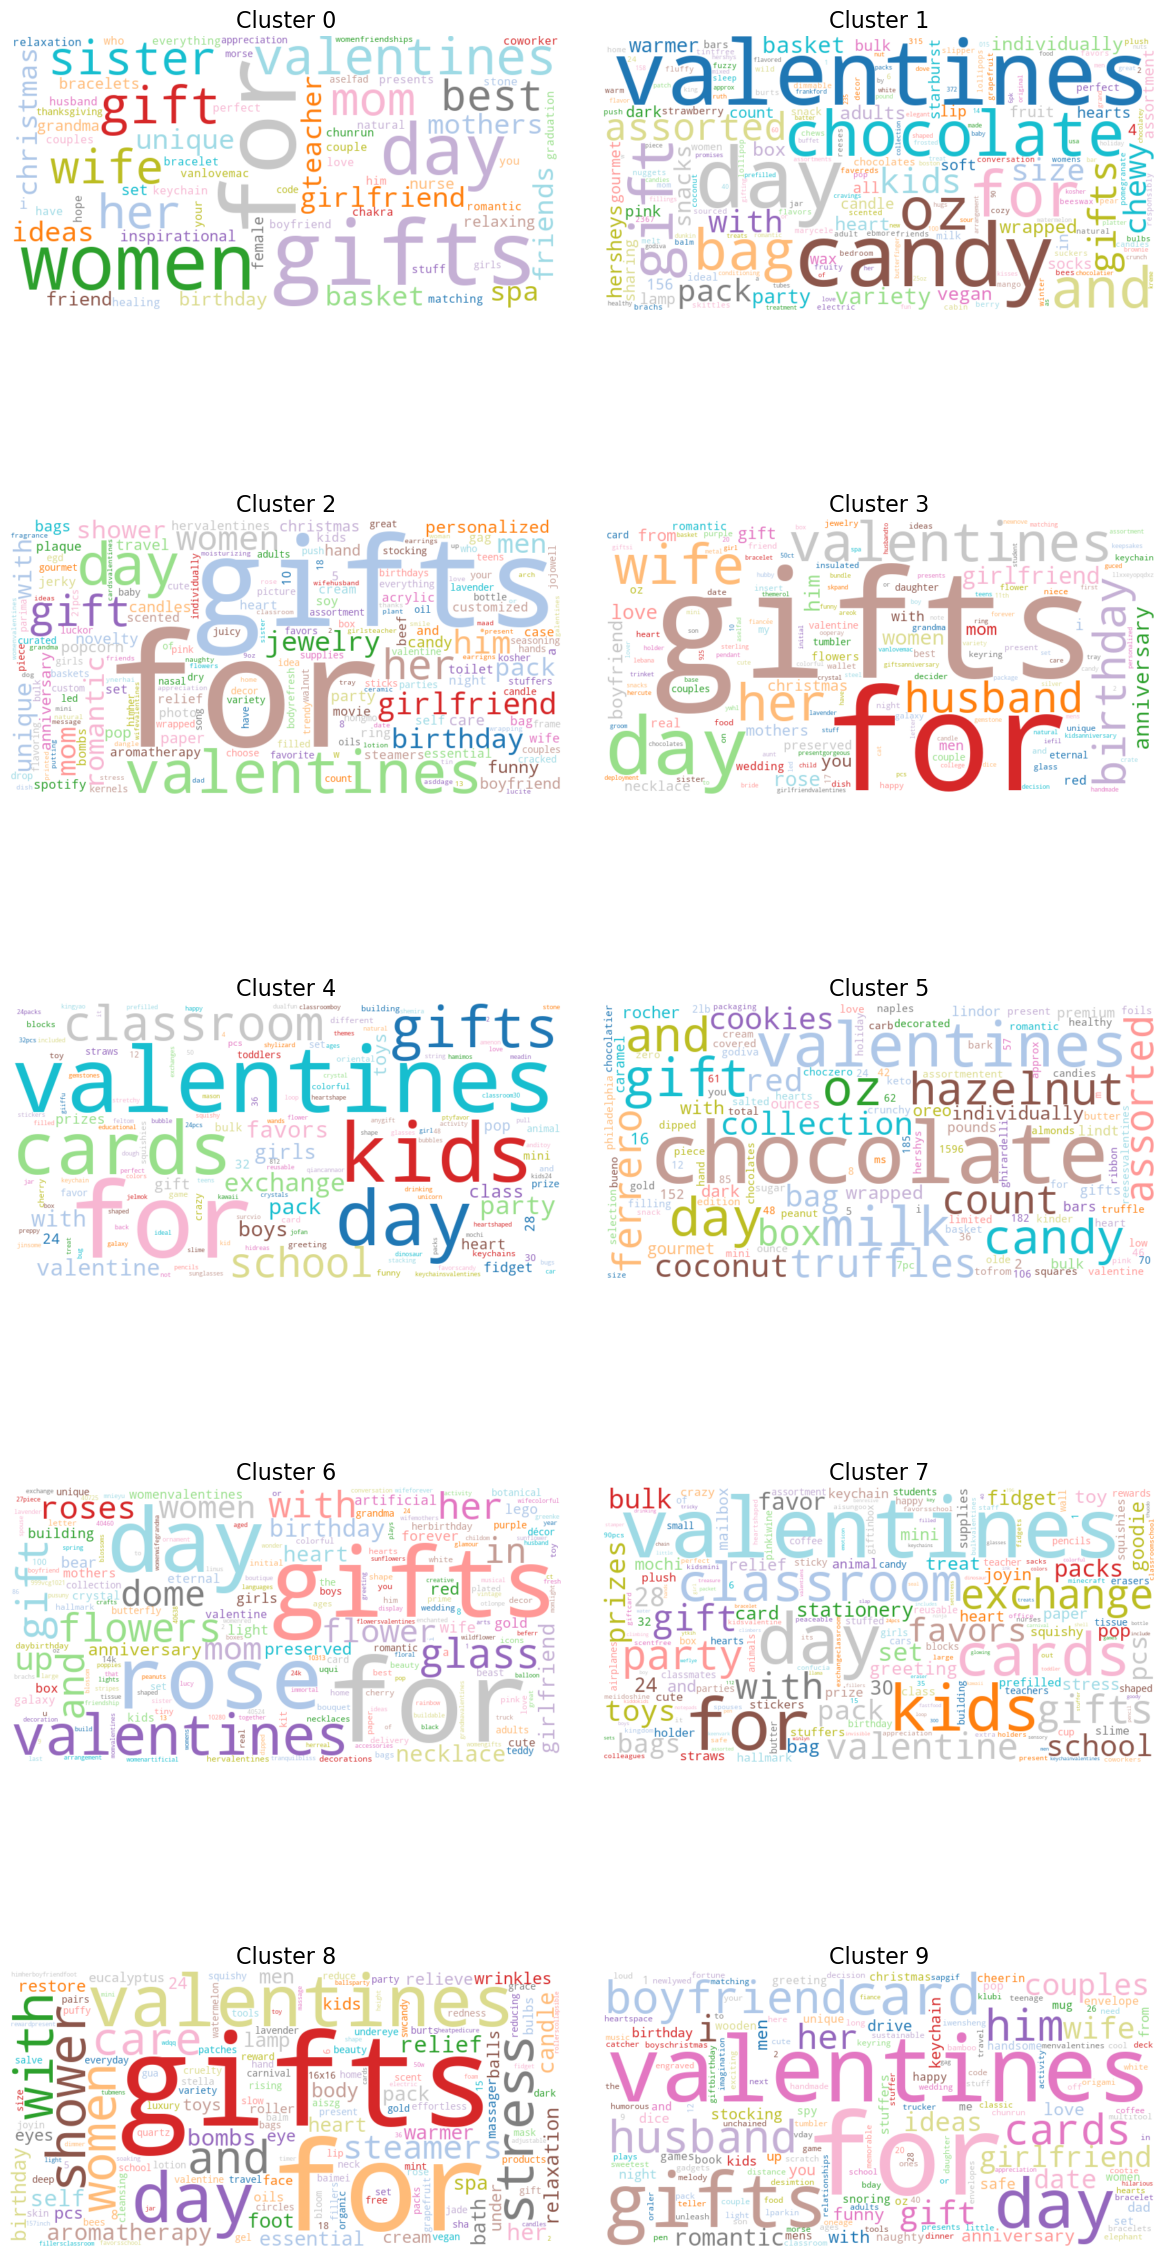

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

clusters = sorted(dfCopy['Cluster'].unique())

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 25))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    cluster_titles = dfCopy[dfCopy['Cluster'] == cluster]['Refined Title']
    
    cluster_text = ' '.join([title for title in cluster_titles if isinstance(title, str)])
    
    cluster_text = re.sub(r'[^\w\s]', '', cluster_text)
    
    words = cluster_text.split()
    
    word_freq = Counter(words)
    
    if len(word_freq) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20').generate_from_frequencies(word_freq)
        
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')  # Hide the axes
        ax.set_title(f'Cluster {cluster}', fontsize=16)
    else:
        ax = axes[i]
        ax.text(0.5, 0.5, 'No words', fontsize=20, ha='center', va='center')
        ax.axis('off')

if len(clusters) < len(axes):
    for j in range(len(clusters), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(pad=2.0, w_pad=3.0, h_pad=5.0)
plt.show()


ĐIỀN TÊN CHO CÁC CỤM

In [13]:
cluster_to_job_title = {
    0: "Best Valentine's gifts for women",
    1: "Valentine's Day gift bag with assorted candy and chocolate",
    2: "Romantic personalized jewelry gifts for Valentine’s Day",
    3: "Rose gifts for wife on Valentine's Day",
    4: "Gifts and cards to girls on Valentine's Day",
    5: "Assorted chocolate truffles and cookies gift box",
    6: "Glass necklace and rose for Valentine's gift",
    7: "Gift cards for kids to exchange on Valentine’s Day",
    8: "Gifts for Valentine's Day with candle and relaxation care",
    9: "Valentine's Day card ideas for couples"
}

dfCopy['Gift Title Roles'] = dfCopy['Cluster'].map(cluster_to_job_title)

dfCopy.head(5)

,title,brand,description,starsBreakdown/3star,starsBreakdown/4star,starsBreakdown/5star,reviewsCount,price,price/currency,price/value,categoryPageData/productPosition,Refined Title,Vector,Cluster,Gift Title Roles
0,"Ferrero Rocher, 24 Count, Premium Milk Chocola...",Ferrero Rocher,Ferrero Rocher's milk chocolate gift box offer...,0.02,0.07,0.89,20021.0,NaN,$,11.39,7,ferrero rocher 24 count premium milk chocolate...,"[-0.04784686, 0.32031354, -0.18485427, 0.09783...",5,Assorted chocolate truffles and cookies gift box
1,"HERSHEY'S NUGGETS Assorted Chocolate, Valentin...",HERSHEY'S,This HERSHEY'S NUGGETS candy assortment is fil...,0.03,0.10,0.84,18891.0,NaN,$,10.69,16,hersheys nuggets assorted chocolate valentines...,"[-0.09465036270293323, 0.15106291332366792, -0...",1,Valentine's Day gift bag with assorted candy a...
2,LEGO Icons Flower Bouquet Building Decoration ...,LEGO,Giving and receiving beautiful flowers is such...,0.01,0.05,0.92,19395.0,NaN,$,47.99,2,lego icons flower bouquet building decoration ...,"[0.2082137249667069, 0.5833509346341779, -0.38...",6,Glass necklace and rose for Valentine's gift
3,BodyRefresh Shower Steamers Aromatherapy - 8 P...,BodyRefresh,NaN,0.07,0.15,0.67,593.0,NaN,$,9.99,10,bodyrefresh shower steamers aromatherapy 8 pa...,"[0.15067462963010517, 0.4685303956669356, -0.2...",2,Romantic personalized jewelry gifts for Valent...
4,JoJowell Shower Steamers Aromatherapy - 21Pcs ...,JoJowell,NaN,0.10,0.15,0.63,816.0,NaN,$,21.99,11,jojowell shower steamers aromatherapy 21pcs s...,"[0.25322112383858847, 0.4304769345527065, -0.2...",2,Romantic personalized jewelry gifts for Valent...


LƯU VÀO BỘ DỮ LIỆU

In [14]:
dfCopy.to_csv('valentine gift.csv', index=False)